# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que há disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução desenvolvida aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [61]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import os

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split



### 

In [2]:


# Dicionário dos meses
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

# Caminho para o diretório onde o Jupyter está executando
diretorio_atual = pathlib.Path.cwd()

# Caminho para a pasta 'dataset', subindo um nível (saindo de 'notebooks' e indo para 'airbnb-pricing-rio') e acessando 'dataset'
caminho_bases = diretorio_atual.parent / 'dataset'

# DataFrame vazio para concatenar os dados
base_airbnb = pd.DataFrame()

# Verifica se o caminho existe
if caminho_bases.exists() and caminho_bases.is_dir():
    print(f"O caminho encontrado é: {caminho_bases}")  # Para verificar o caminho correto
    # Itera pelos arquivos na pasta 'dataset'
    for arquivo in caminho_bases.iterdir():
        nome_mes = arquivo.name[:3]  # Extrai o nome do mês
        mes = meses[nome_mes]  # Converte o nome do mês para número
        
        # Extrai o ano
        ano = arquivo.name[-8:]
        ano = int(ano.replace('.csv', ''))
        
        # Carrega o arquivo CSV
        df = pd.read_csv(arquivo)
        df['ano'] = ano
        df['mes'] = mes
        
        # Concatena os dados no DataFrame final
        base_airbnb = pd.concat([base_airbnb, df], ignore_index=True)

    # Exibe o DataFrame final
    display(base_airbnb)
else:
    print(f"O diretório '{caminho_bases}' não foi encontrado.")



O caminho encontrado é: c:\Users\GUILHERME\OneDrive\Área de Trabalho\Hashtag aulas\Python\airbnb-pricing-rio\dataset


C:\Users\GUILHERME\AppData\Local\Temp\ipykernel_2800\770044410.py:26: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(arquivo)
C:\Users\GUILHERME\AppData\Local\Temp\ipykernel_2800\770044410.py:26: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(arquivo)
C:\Users\GUILHERME\AppData\Local\Temp\ipykernel_2800\770044410.py:26: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(arquivo)
C:\Users\GUILHERME\AppData\Local\Temp\ipykernel_2800\770044410.py:26: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(arquivo)
C:\Users\GUILHERME\AppData\Local\Temp\ipykernel_2800\770044410.py:26: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.re

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews_ltm,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,14063,https://www.airbnb.com/rooms/14063,20180414160018,2018-04-14,Living in a Postcard,"Besides the most iconic's view, our apartment ...",NaN,"Besides the most iconic's view, our apartment ...",none,Best and favorite neighborhood of Rio. Perfect...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17878,https://www.airbnb.com/rooms/17878,20180414160018,2018-04-14,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for New Y...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for New Y...,none,This is the best spot in Rio. Everything happe...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24480,https://www.airbnb.com/rooms/24480,20180414160018,2018-04-14,Nice and cozy near Ipanema Beach,My studio is located in the best of Ipanema. ...,The studio is located at Vinicius de Moraes St...,My studio is located in the best of Ipanema. ...,none,"The beach, the lagoon, Ipanema is a great loca...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25026,https://www.airbnb.com/rooms/25026,20180414160018,2018-04-14,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31560,https://www.airbnb.com/rooms/31560,20180414160018,2018-04-14,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902205,38844730,https://www.airbnb.com/rooms/38844730,20190923212307,2019-09-24,TRANSAMERICA BARRA DA TIJUCA R IV,"Em estilo contemporâneo, o Transamerica Prime ...",NaN,"Em estilo contemporâneo, o Transamerica Prime ...",none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,15.0,0.0,0.0
902206,38846408,https://www.airbnb.com/rooms/38846408,20190923212307,2019-09-24,Alugo para o Rock in Rio,"Confortável apartamento, 2 quartos , sendo 1 s...",O apartamento estará com mobília completa disp...,"Confortável apartamento, 2 quartos , sendo 1 s...",none,"Muito próximo ao Parque Olímpico, local do eve...",...,2.0,2.0,1125.0,1125.0,2.0,1125.0,0.0,1.0,0.0,0.0
902207,38846703,https://www.airbnb.com/rooms/38846703,20190923212307,2019-09-24,Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA,Apartamento quarto e sala COMPLETO para curtas...,Espaço ideal para até 5 pessoas. Cama de casal...,Apartamento quarto e sala COMPLETO para curtas...,none,NaN,...,3.0,3.0,1125.0,1125.0,3.0,1125.0,0.0,23.0,6.0,0.0
902208,38847050,https://www.airbnb.com/rooms/38847050,20190923212307,2019-09-24,Cobertura Cinematografica,Cobertura alto nivel,NaN,Cobertura alto nivel,none,NaN,...,1.0,1.0,1125.0,1125.0,1.0,1125.0,0.0,1.0,0.0,0.0


- Como temos muitas colunas nosso modelo pode ficar lento
- Atráves de uma análise rápida é fácil detectar que muitas colunas não serão de ajuda no nosso modelo de previsão por isso iremos exccluir algumas
- Tipos de colunas a serem excluidas: 
    -   id, links e informações não relevantes
    -   Colunas redundantes, exemplo data x ano / mês
    -   Colunas preenchidas por texto livre; não rodaremos analises por texto
    

- Para isso iremos criar um arquivo em excel com 1000 registros para fazer uma análise qualitativa
 

In [3]:
print(list(base_airbnb.columns))
base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')



['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

In [4]:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

base_airbnb = base_airbnb.loc[:, colunas]
print(list(base_airbnb.columns))
display(base_airbnb)

['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'ano', 'mes']


,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,NaN,NaN,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,...,9.0,9.0,9.0,9.0,9.0,f,f,strict_14_with_grace_period,2018,4
1,within an hour,100%,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,...,9.0,10.0,10.0,9.0,9.0,t,f,strict,2018,4
2,within an hour,100%,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
3,within an hour,100%,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
4,within an hour,100%,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,t,f,strict,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902205,within an hour,93%,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
902206,NaN,NaN,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
902207,within a few hours,74%,f,32.0,-22.962080,-43.175520,Apartment,Entire home/apt,5,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9
902208,NaN,NaN,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9


### Consolidar Base de Dados

### Se tivermos muitas colunas, já vamos identificar quais colunas podemos excluir

### Tratar Valores Faltando

- Ao visualizar dados, notamos uma granda massa de valores nulos, então as colunas com mais de 300000 valores Nan iremos excluir da base.
- Para colunas com menos valores NaN, iremos apagar as linhas.

In [5]:


for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)
print(base_airbnb.isnull().sum())



host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


In [6]:
base_airbnb = base_airbnb.dropna()

print(base_airbnb.isnull().sum())

host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

In [7]:
print(base_airbnb.dtypes)
print('-'*60)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                           f
host_listings_count

- Como o preço e as pessoas extras estão sendo reconhecidos como objetos e não float, iremos alterar a variável da coluna

In [8]:
#price
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)
#extra_people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)

print(base_airbnb.dtypes)
print('-'*60)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
------------------------------------------------------------


### Análise Exploratória e Tratar Outliers

### Análise Exploratória e Tratar Outliers

- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

MAS CUIDADO: não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo

<Axes: >

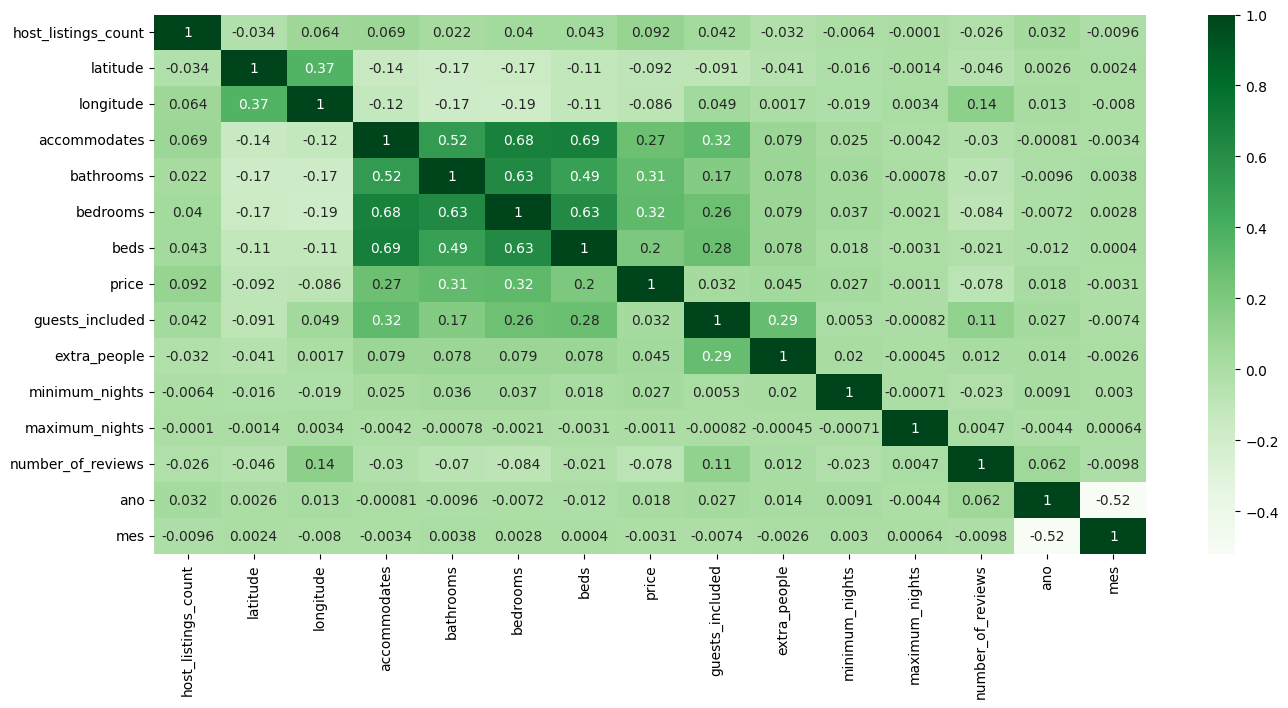

In [9]:
plt.figure(figsize=(16, 7))
sns.heatmap(base_airbnb.corr(numeric_only=True), annot=True, cmap='Greens')

### Definição de Funções para analise de Outliers

Vamos definir algumas funções para ajudar na análise de outliersa


In [10]:
def limites (coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup =limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna]>= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0] 
    return df, linhas_removidas
    


In [11]:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.histplot(coluna, kde=True, kde_kws=dict(cut=3), element='bars', bins=50)
    
def barra(coluna):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))
    

### Price


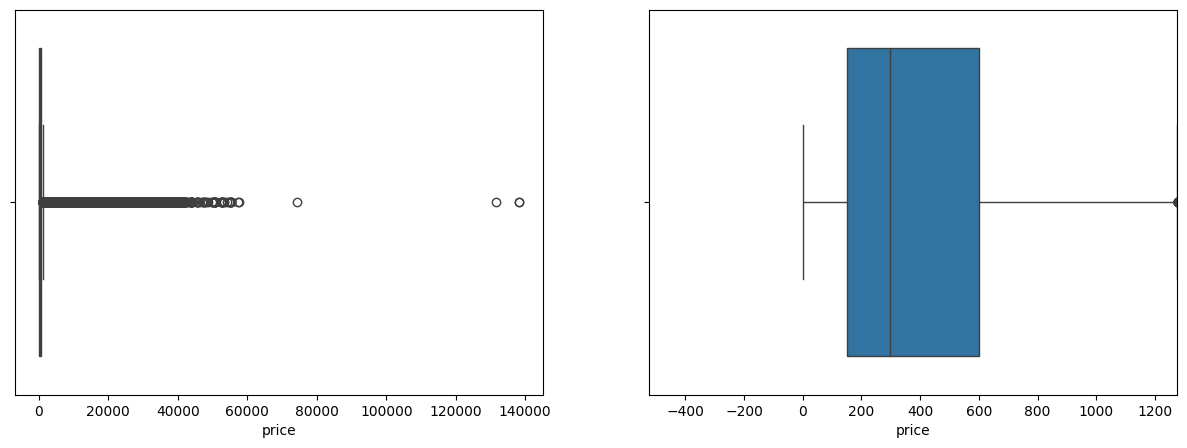

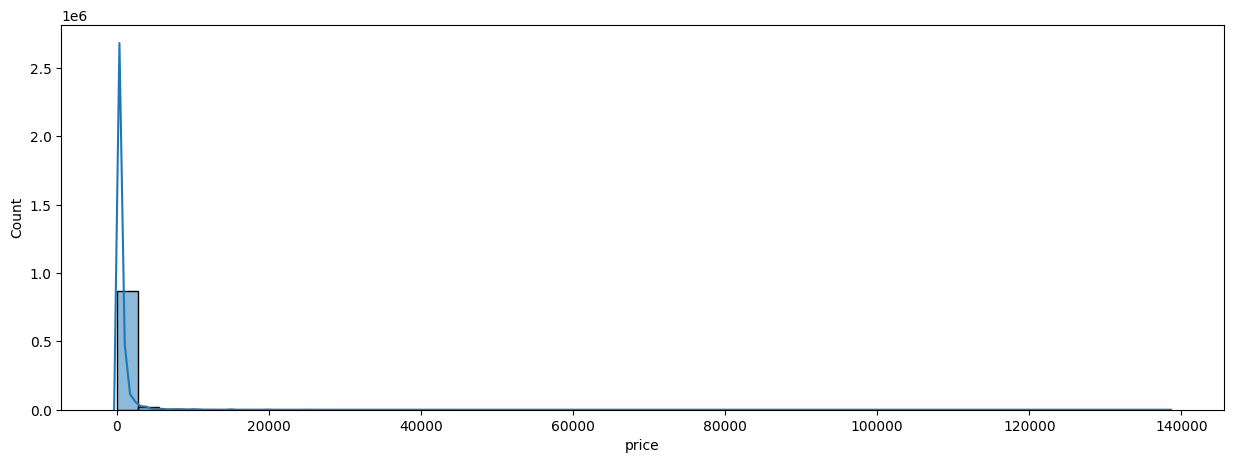

In [12]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

In [13]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print('{} linhas removidas'.format(linhas_removidas))

87282 linhas removidas


 Refazendo o histograma


(810427, 23)


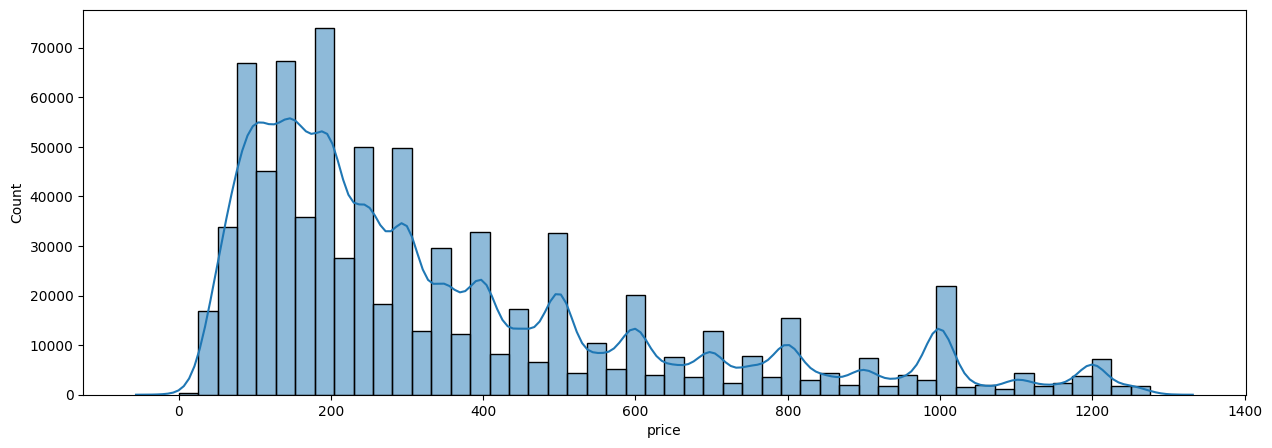

In [14]:
histograma(base_airbnb['price'])
print(base_airbnb.shape)

### Extra People


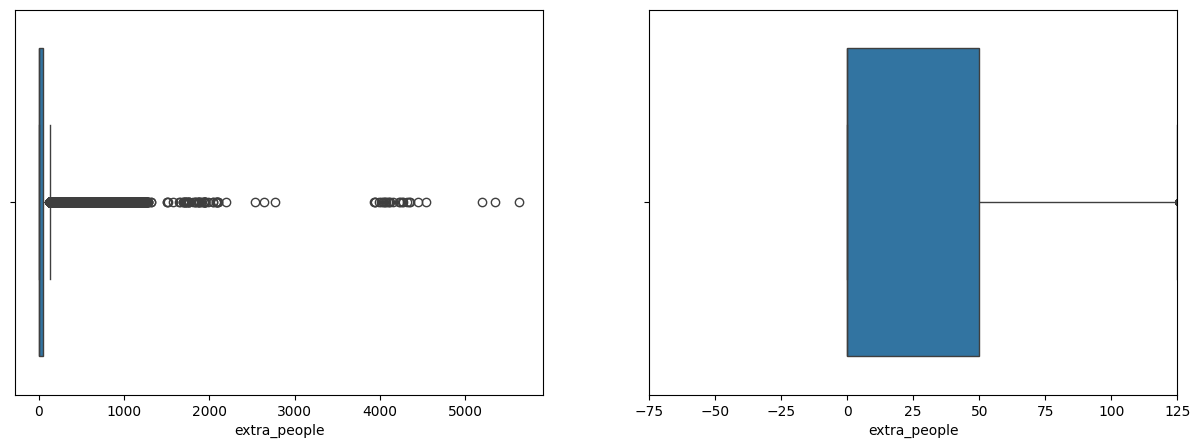

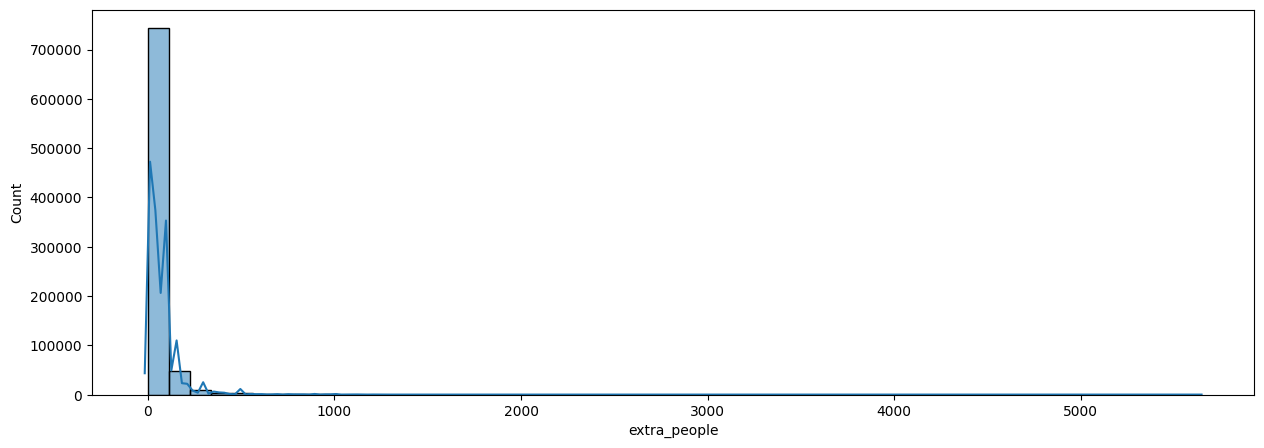

In [15]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

Iremos fazer a exclusão pois as outliers podem influenciar de uma maneira negativa no processo.

59194 linhas removidas
(751233, 23)


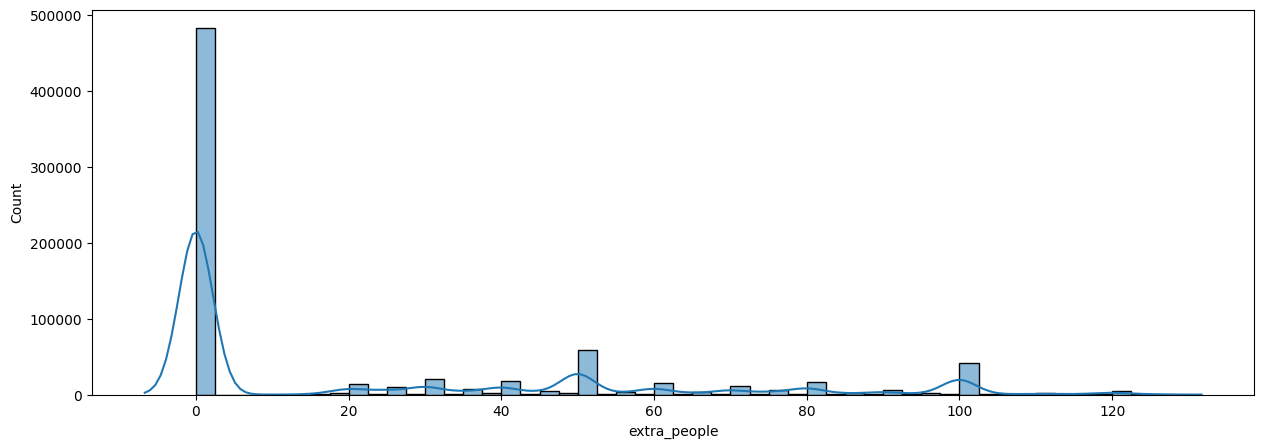

In [16]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print('{} linhas removidas'.format(linhas_removidas))
histograma(base_airbnb['extra_people'])
print(base_airbnb.shape)

### host_list_counts

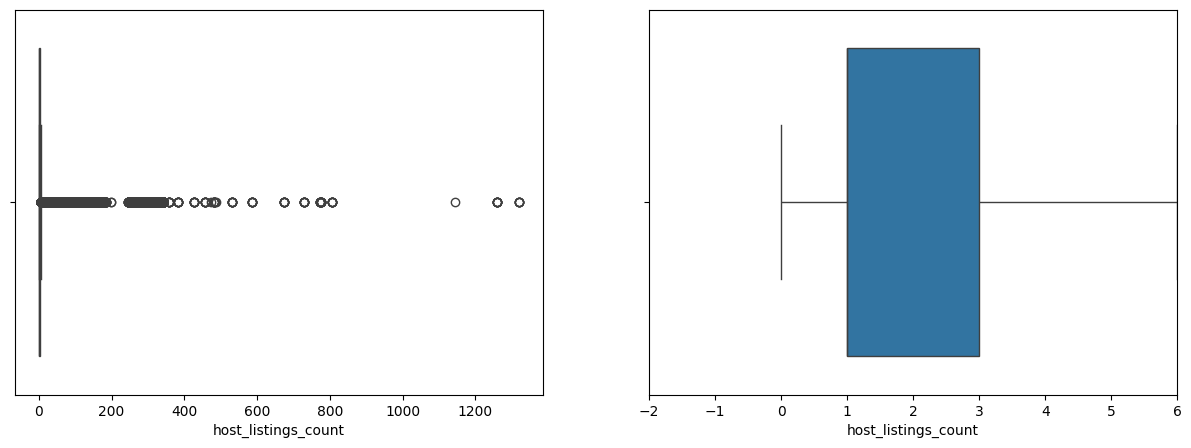

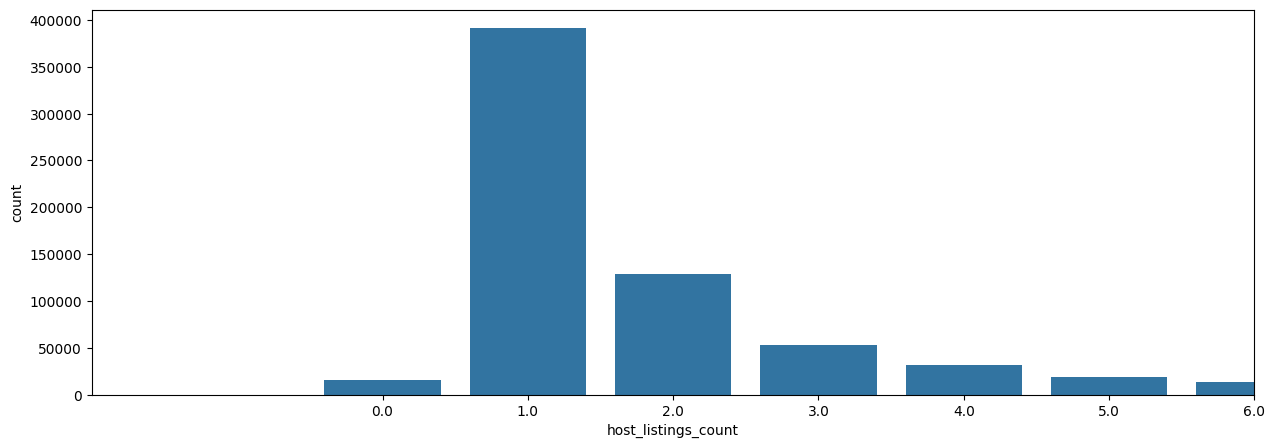

In [17]:
diagrama_caixa(base_airbnb['host_listings_count'])
barra(base_airbnb['host_listings_count'])

### Iremos excluir os outliers pois não é o objetivo acatar host com mais de 6 imóveis

97723 linhas removidas
(653510, 23)


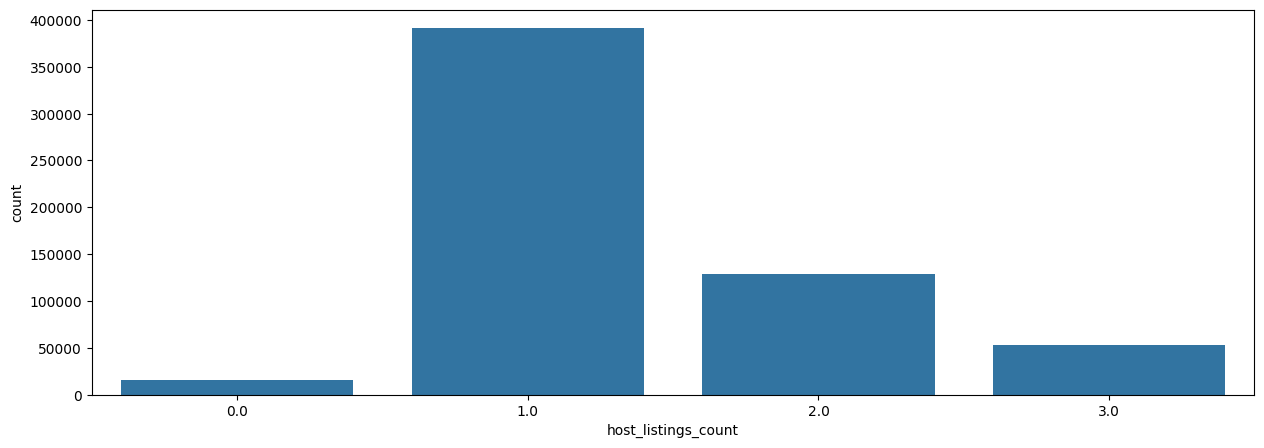

In [18]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print('{} linhas removidas'.format(linhas_removidas))
barra(base_airbnb['host_listings_count'])
print(base_airbnb.shape)

### accomodates

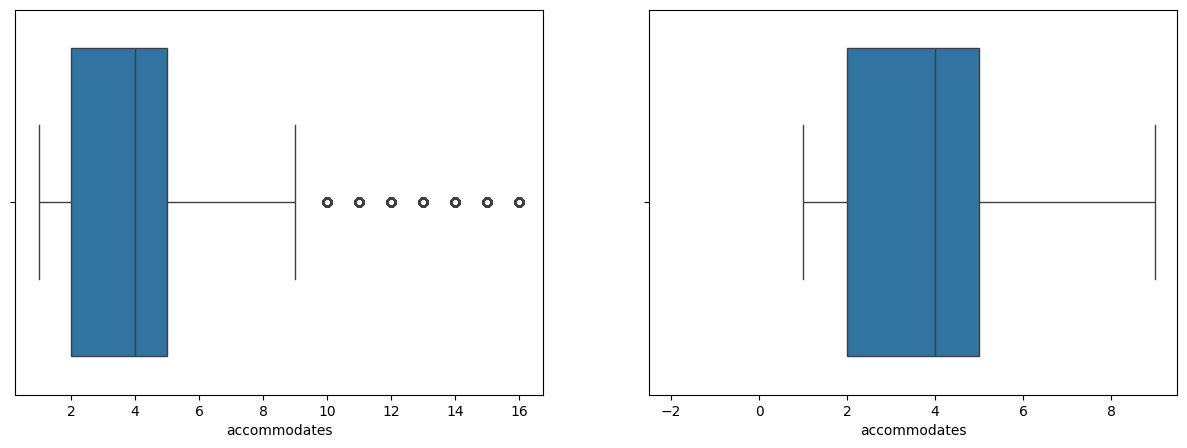

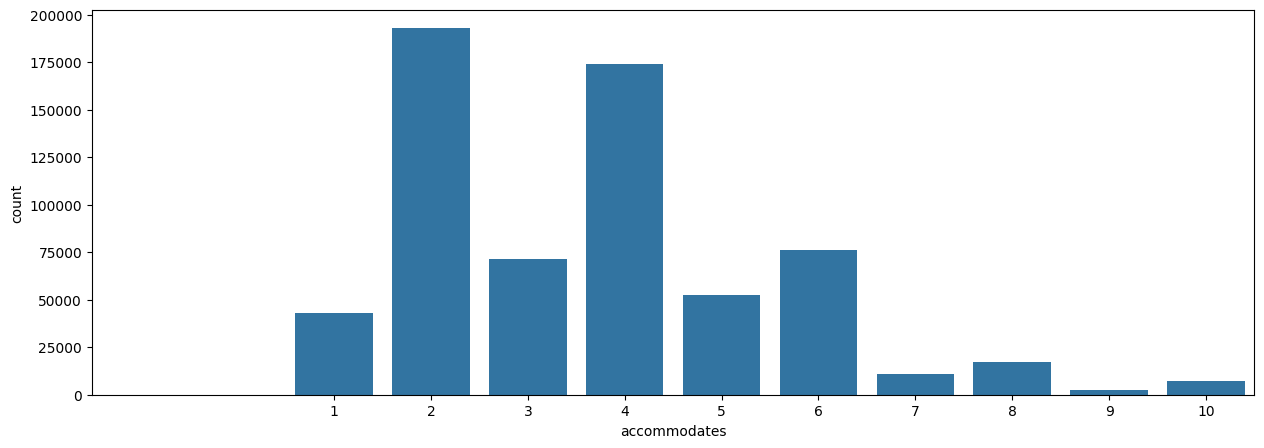

In [19]:
diagrama_caixa(base_airbnb['accommodates'])
barra(base_airbnb['accommodates'])

Excluimos pois uma casa que acomode mais de 10 pessoas não seria uma casa "Padrão" para o modelo.

13146 linhas removidas
(640364, 23)


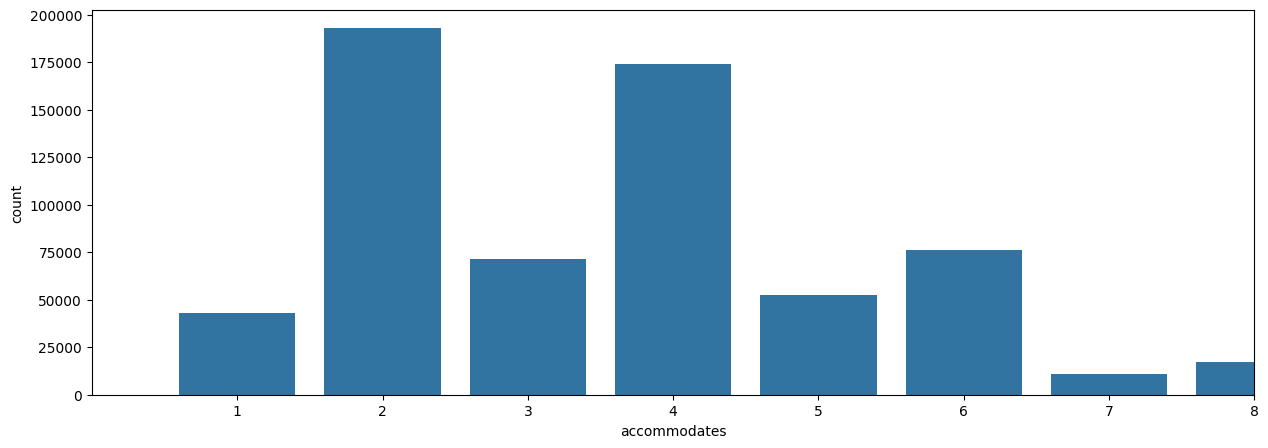

In [20]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print('{} linhas removidas'.format(linhas_removidas))
barra(base_airbnb['accommodates'])
print(base_airbnb.shape)

### Bathrooms

<Axes: xlabel='bathrooms', ylabel='count'>

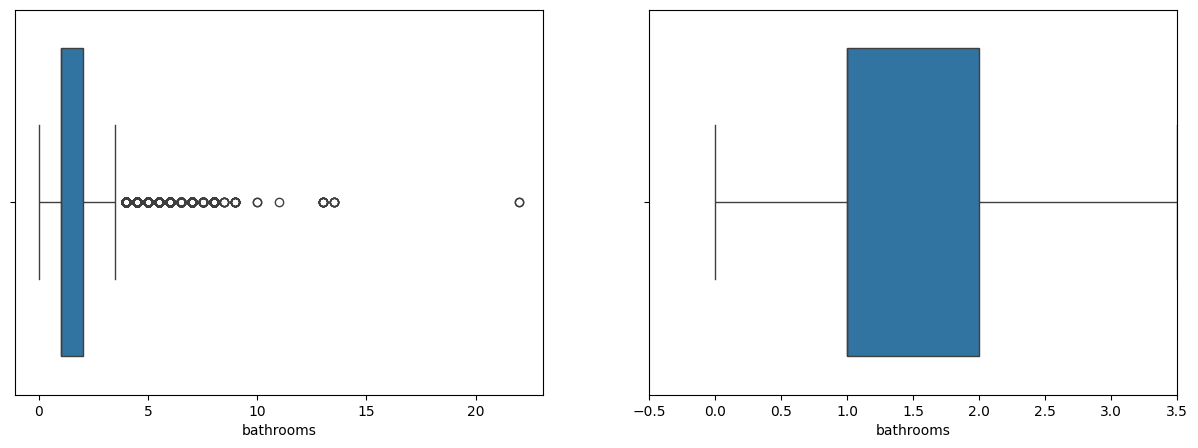

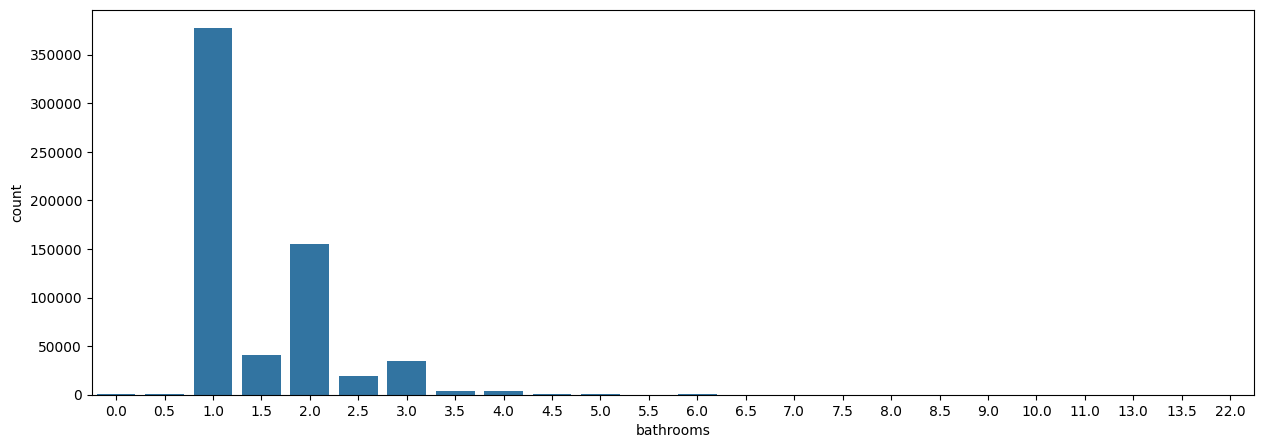

In [21]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

Excluimos pois pro nosso modelo Não faz sentido

6894 linhas removidas


<Axes: xlabel='bathrooms', ylabel='count'>

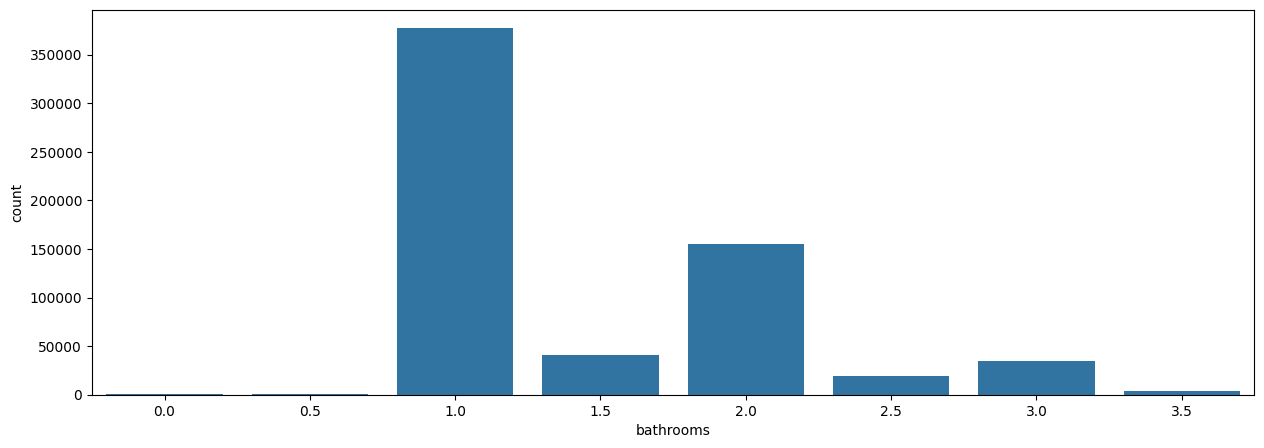

In [22]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print('{} linhas removidas'.format(linhas_removidas))
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

### bedrooms

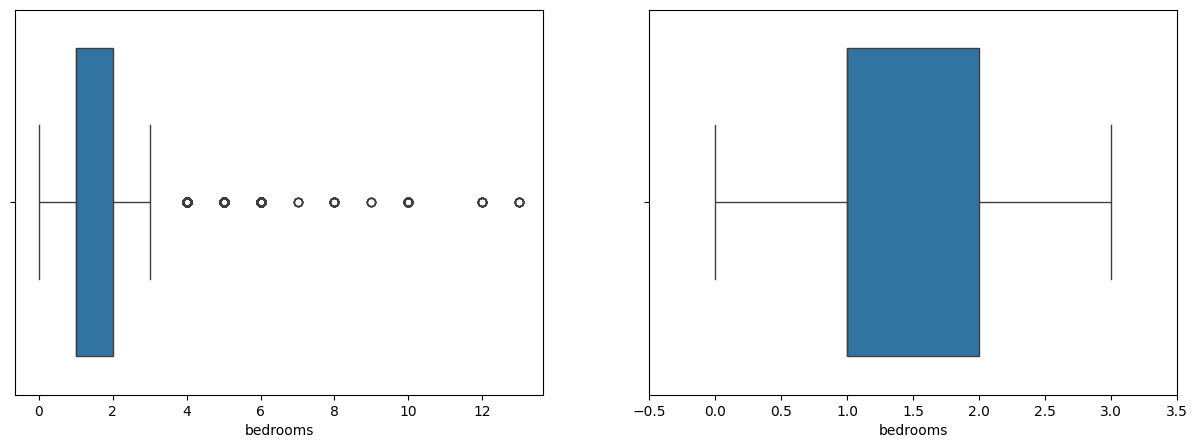

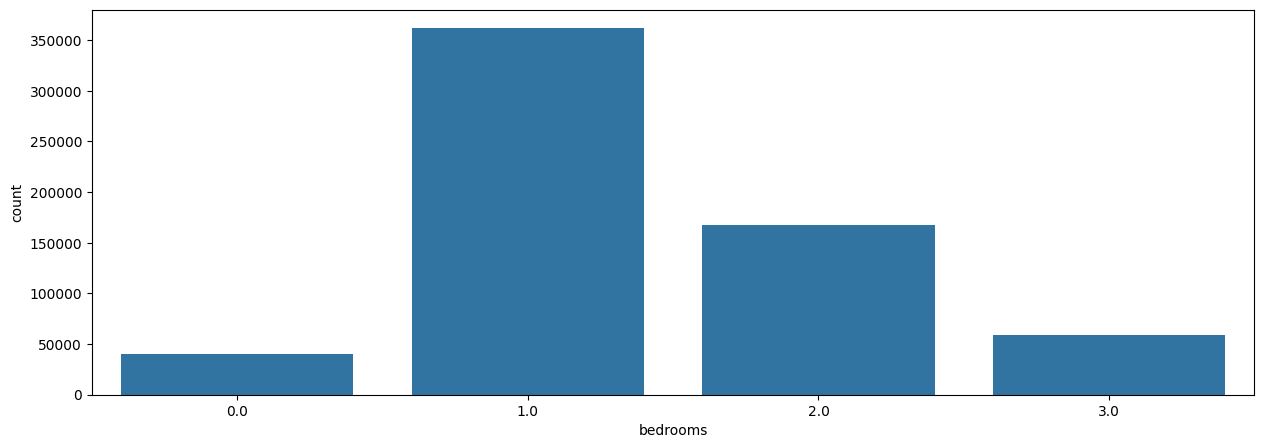

In [23]:
diagrama_caixa(base_airbnb['bedrooms'])
barra(base_airbnb['bedrooms'])

Exclusão feita pelo fato de que casas com muitos quartos não são casas que nosso modelo irá avaliar

5482 linhas removidas
(627988, 23)


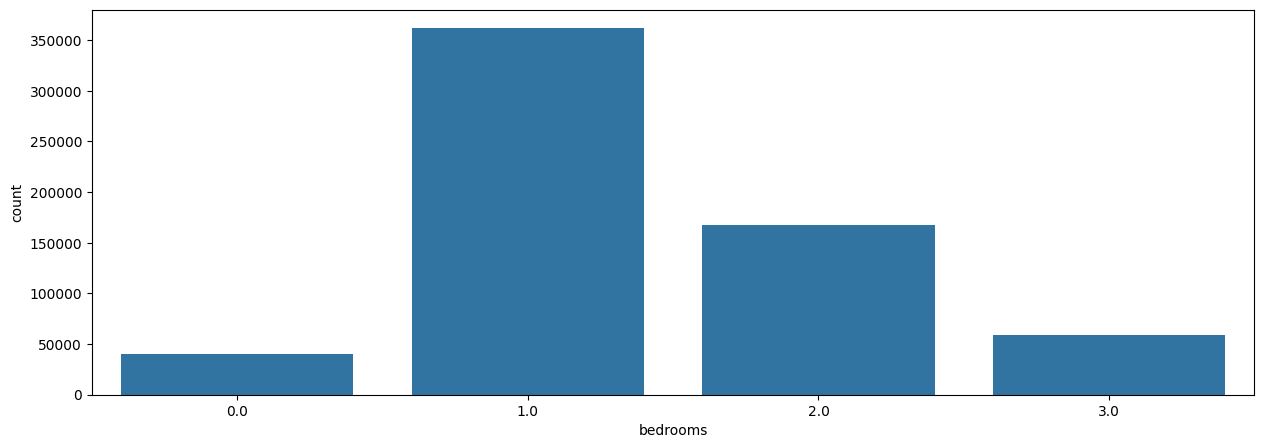

In [24]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print('{} linhas removidas'.format(linhas_removidas))
barra(base_airbnb['bedrooms'])
print(base_airbnb.shape)

### Beds


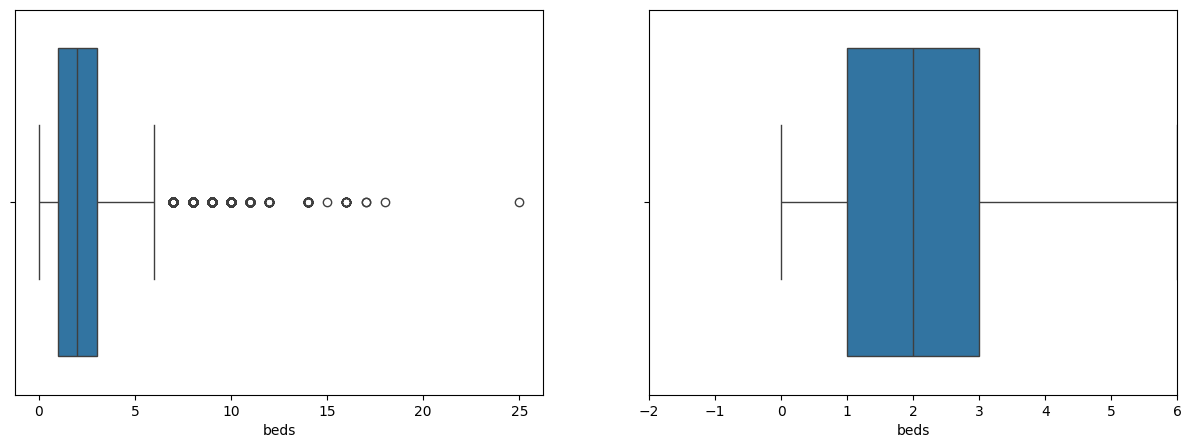

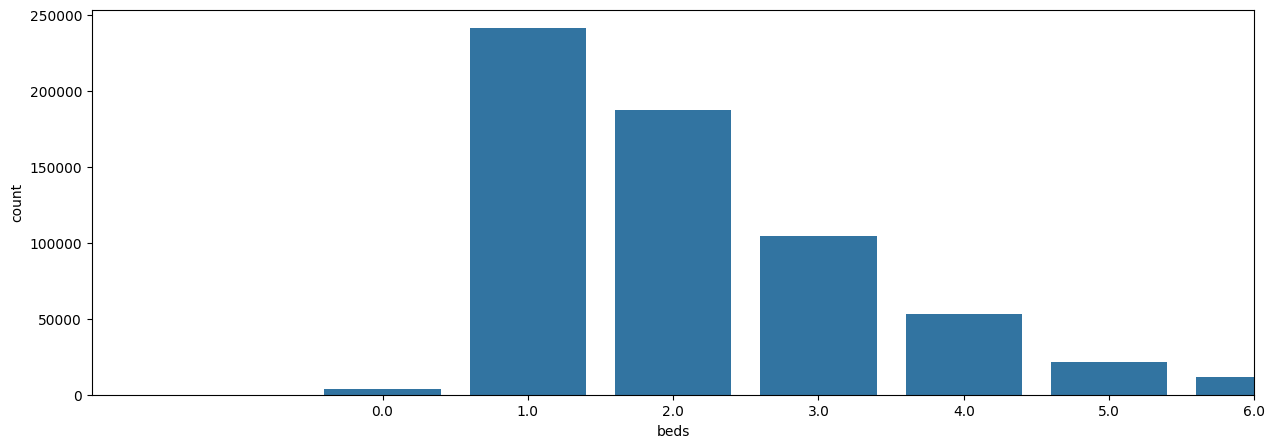

In [25]:
diagrama_caixa(base_airbnb['beds'])
barra(base_airbnb['beds'])

Mesmo motivo da exclusão de quartos

5622 linhas removidas
(622366, 23)


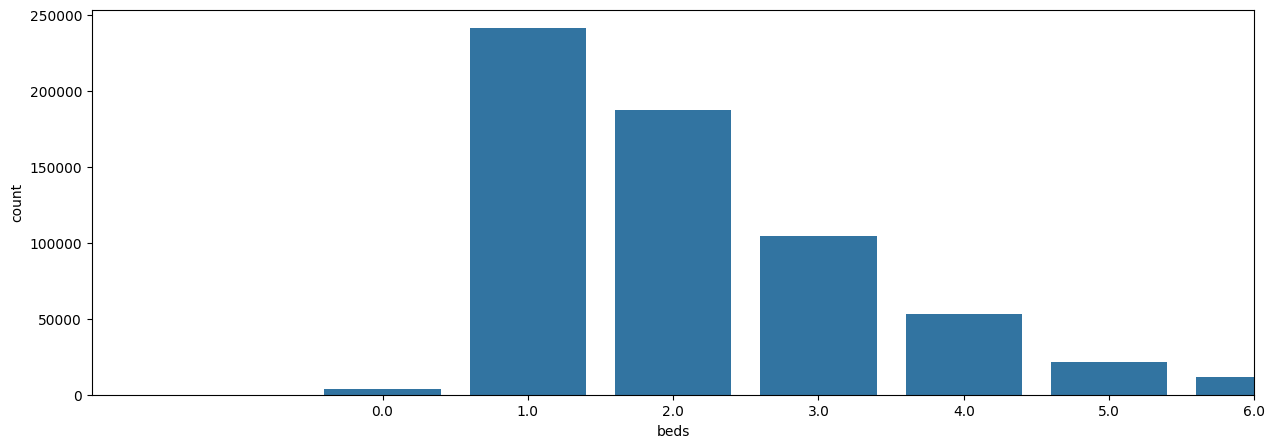

In [26]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print('{} linhas removidas'.format(linhas_removidas))
barra(base_airbnb['beds'])
print(base_airbnb.shape)

### guests_included

<function limites at 0x00000212FDB540E0>


C:\Users\GUILHERME\AppData\Local\Temp\ipykernel_2800\4200863344.py:5: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim(limites(coluna))


<Axes: xlabel='guests_included', ylabel='count'>

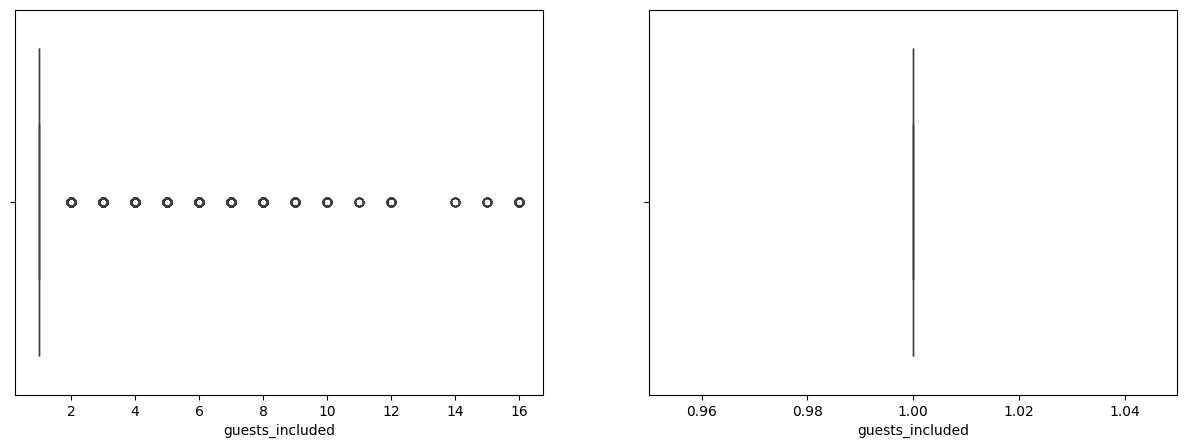

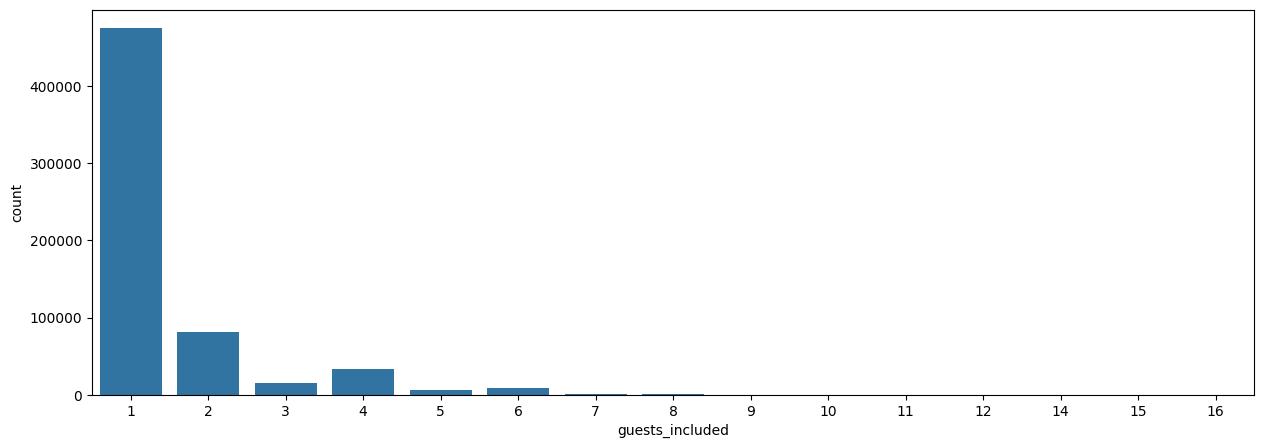

In [27]:
### diagrama_caixa(base_airbnb['guests_included'])
### barra(base_airbnb['guests_included'])
print(limites)

diagrama_caixa(base_airbnb['guests_included'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

In [28]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(622366, 22)

Vamos remover essa feature da análise. Parece que os usuários do airbnb usam muito o valor padrão do airbnb como 1 guest included. Isso pode levar o nosso modelo a considerar uma feature que na verdade não é essencial para a definição do preço, por isso, me parece melhor excluir a coluna da análise

#### minimum_nights 

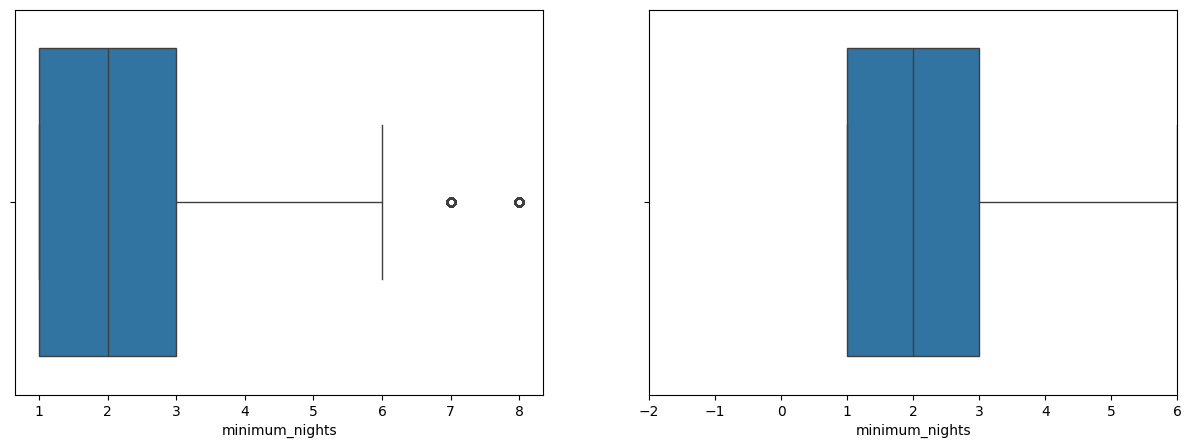

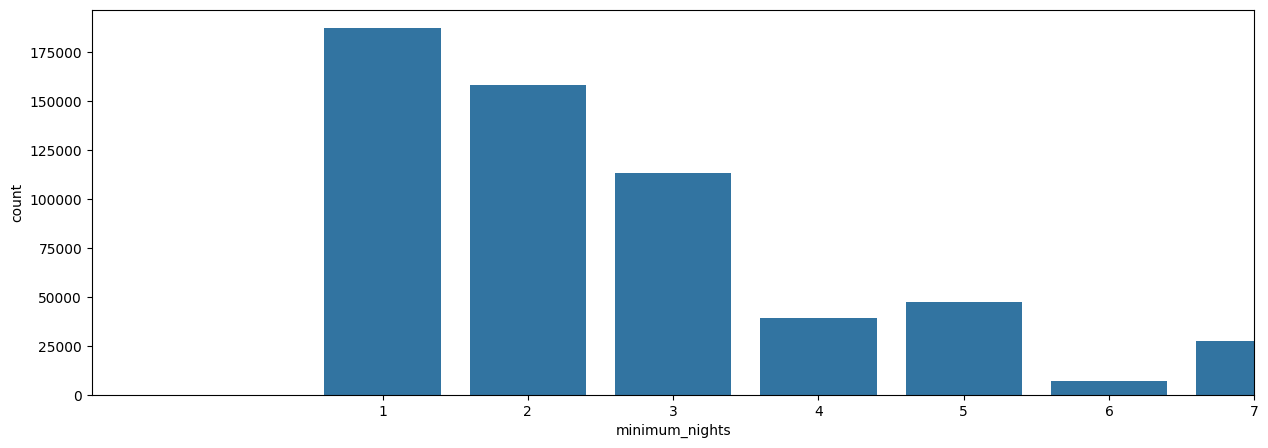

In [33]:
diagrama_caixa(base_airbnb['minimum_nights'])
barra(base_airbnb['minimum_nights'])

- Aqui temos um motivo talvez até mais forte para excluir esses apartamentos da análise.

- Estamos querendo um modelo que ajude a precificar apartamentos comuns como uma pessoa comum gostaria de disponibilizar. No caso, apartamentos com mais de 8 noites como o "mínimo de noites" podem ser apartamentos de temporada ou ainda apartamentos para morar, em que o host exige pelo menos 1 mês no apartamento.

- Por isso, vamos excluir os outliers dessa coluna

40383 minimum_nights
(581983, 22)


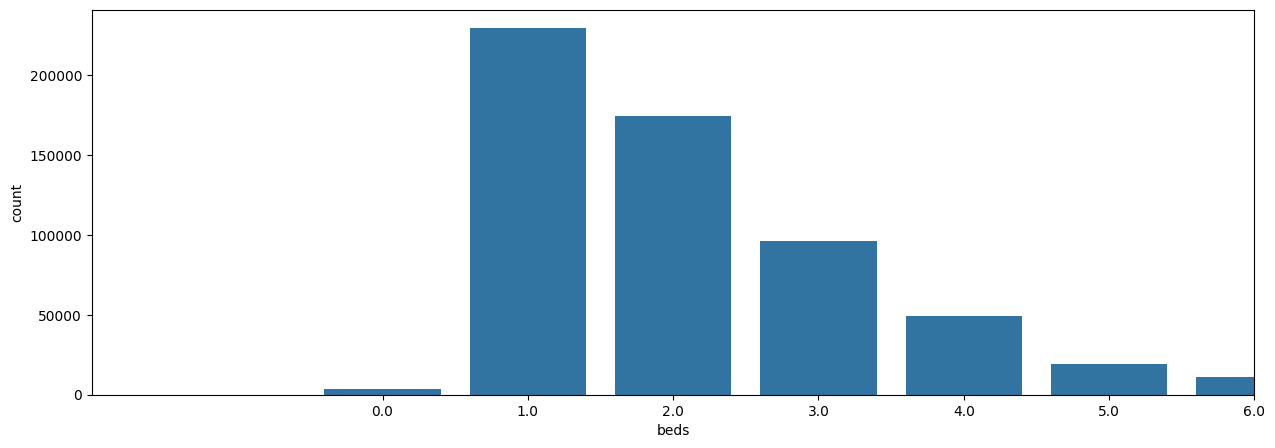

In [30]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print('{} minimum_nights'.format(linhas_removidas))
barra(base_airbnb['beds'])
print(base_airbnb.shape)

#### maximum_nights  

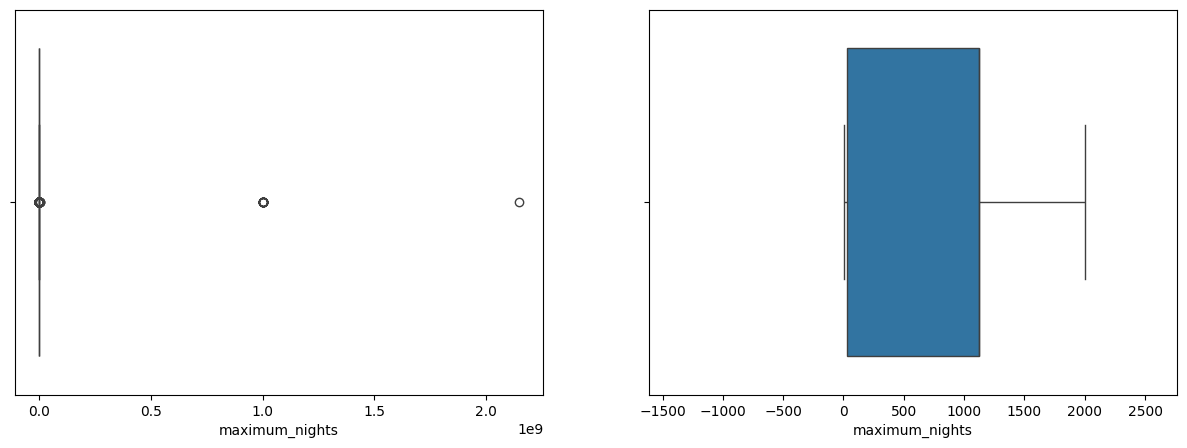

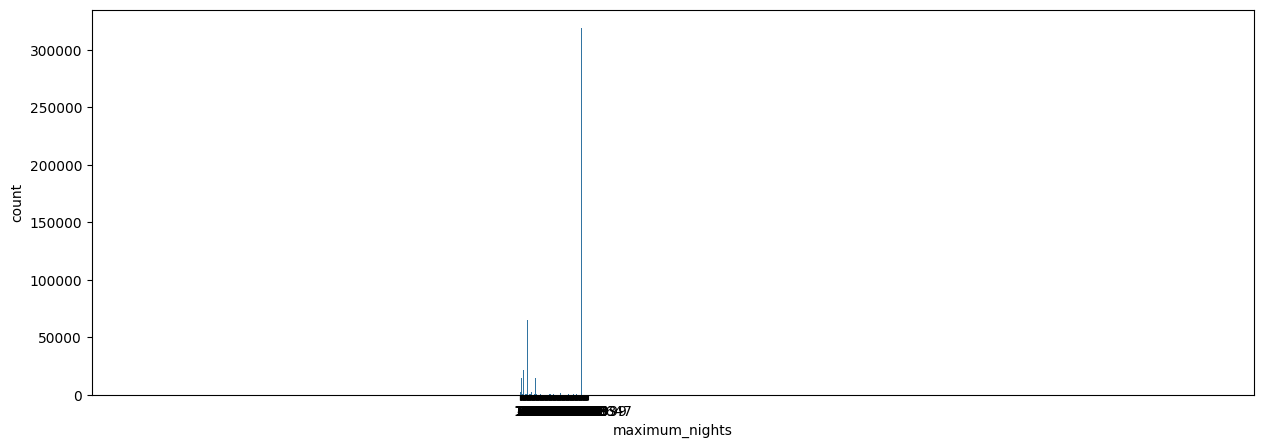

In [31]:
diagrama_caixa(base_airbnb['maximum_nights'])
barra(base_airbnb['maximum_nights'])

- Essa coluna não parece que vai ajudar na análise.

- Isso porque parece que quase todos os hosts não preenchem esse campo de maximum nights, então ele não parece que vai ser um fator relevante.

- É melhor excluirmos essa coluna da análise

187 maximum_nights
(581796, 22)


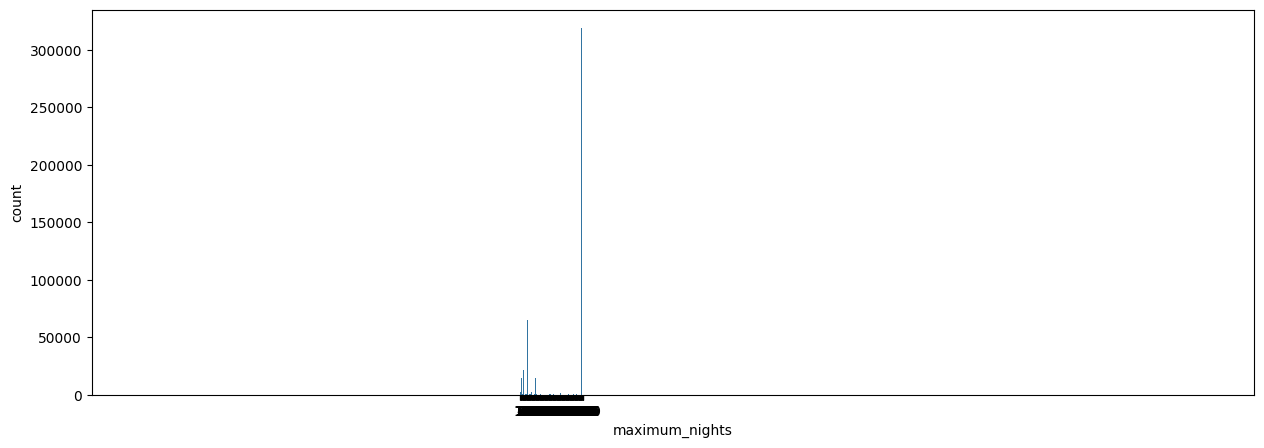

In [32]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'maximum_nights')
print('{} maximum_nights'.format(linhas_removidas))
barra(base_airbnb['maximum_nights'])
print(base_airbnb.shape)

In [34]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(581796, 21)

### number_of_reviews 

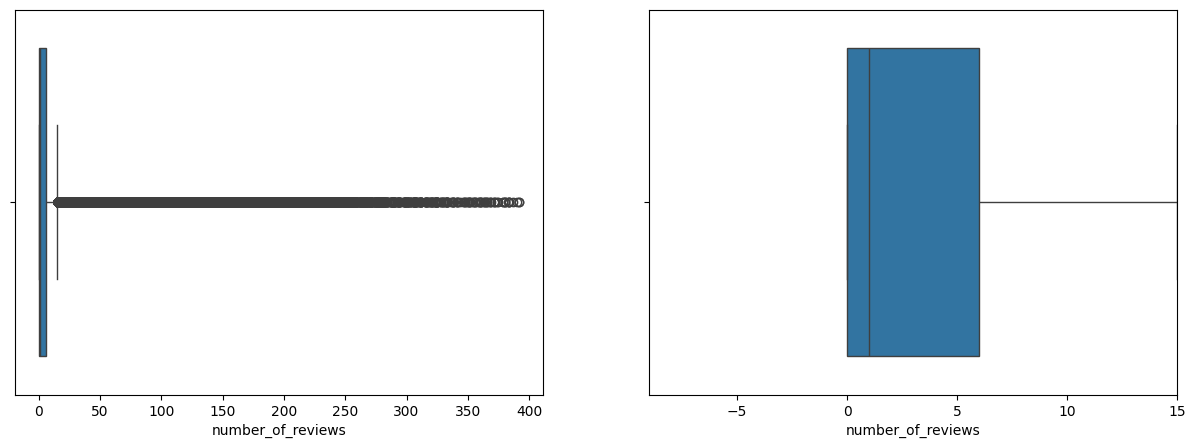

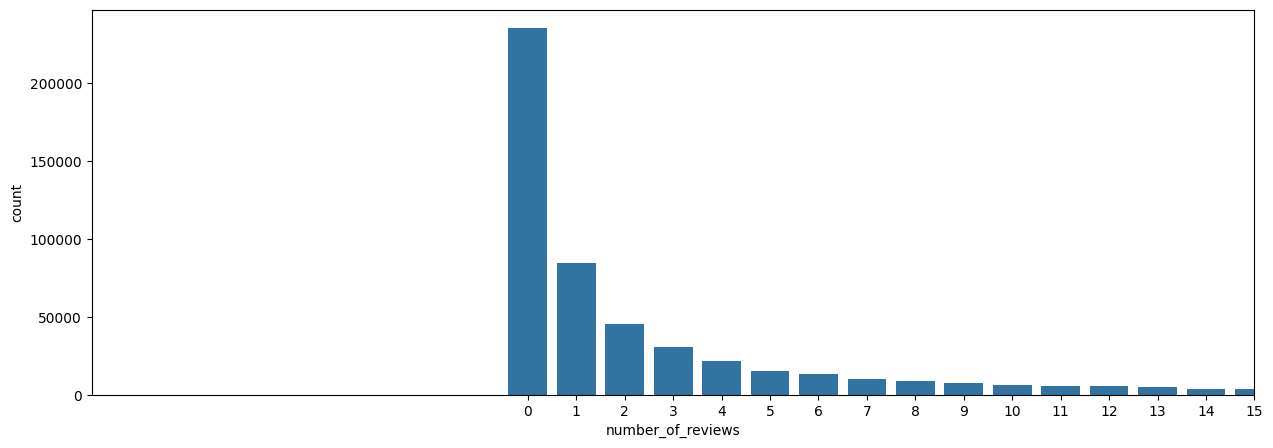

In [35]:
diagrama_caixa(base_airbnb['number_of_reviews'])
barra(base_airbnb['number_of_reviews'])

O número de Reviews é um número que pode e não pode impactar na nossa análise, eu optei por deixar.

### Tratamento de Colunas de Valores de Texto

### - property_type 

property_type
Apartment                 458189
House                      51370
Condominium                26456
Serviced apartment         12666
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                     

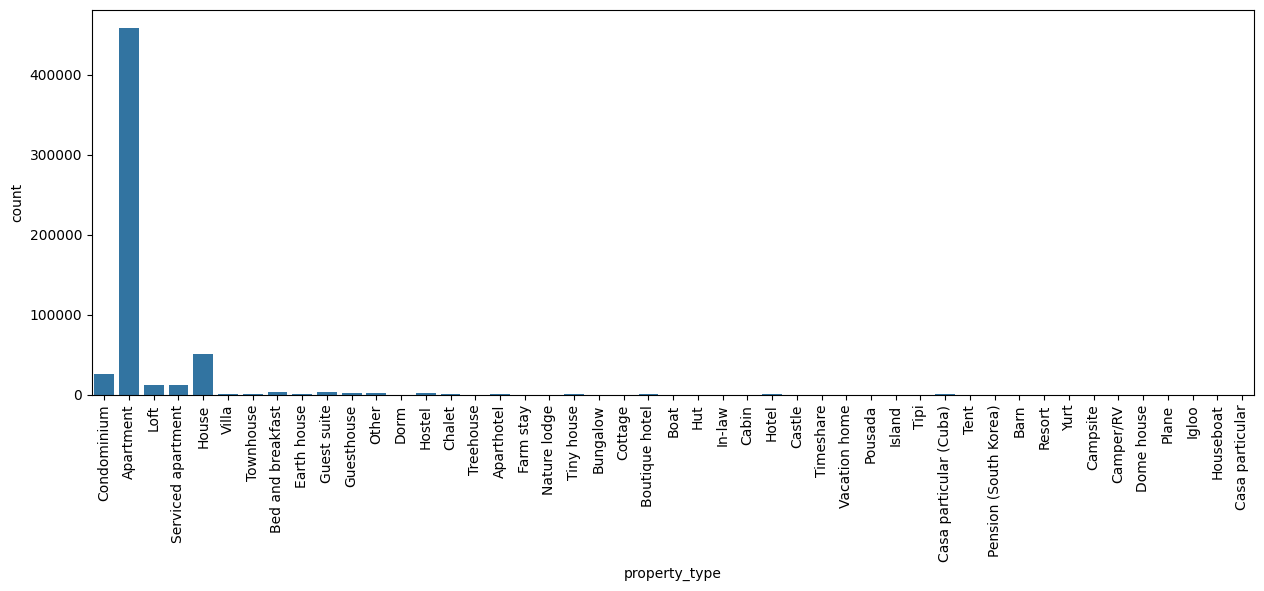

In [36]:
print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base_airbnb, x='property_type')
grafico.tick_params(axis='x', rotation=90 )

Nota-se que a partir de Outros os valores são abaixo de 2000 então iremos agrupar todos os valores menores que 2000 junto com os Outros

['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'Igloo', 'In-law', 'Vacation home', 'Timeshare', 'Pousada', 'Houseboat', 'Casa particular', 'Plane']
property_type
Apartment             458189
House                  51370
Condominium            26456
Serviced apartment     12666
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: count, dtype: int64


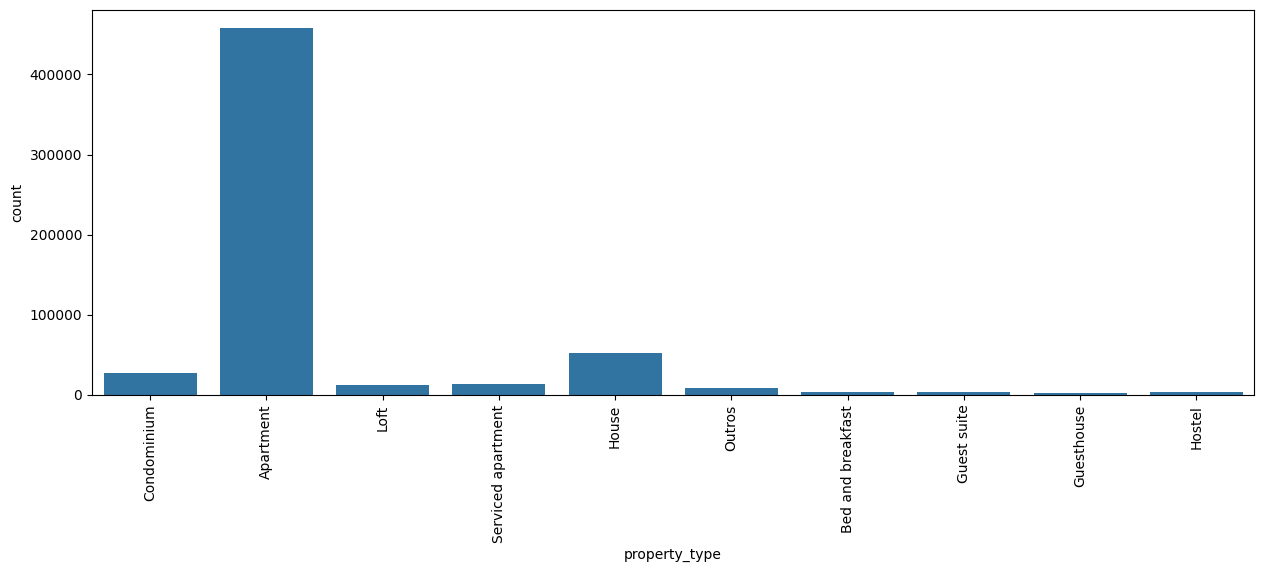

In [37]:
tabela_tipos_casa = base_airbnb['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2071:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type']==tipo, 'property_type'] = 'Outros'

print(base_airbnb['property_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base_airbnb, x='property_type')
grafico.tick_params(axis='x', rotation=90 )

### room_type 

room_type
Entire home/apt    372268
Private room       196851
Shared room         11710
Hotel room            967
Name: count, dtype: int64


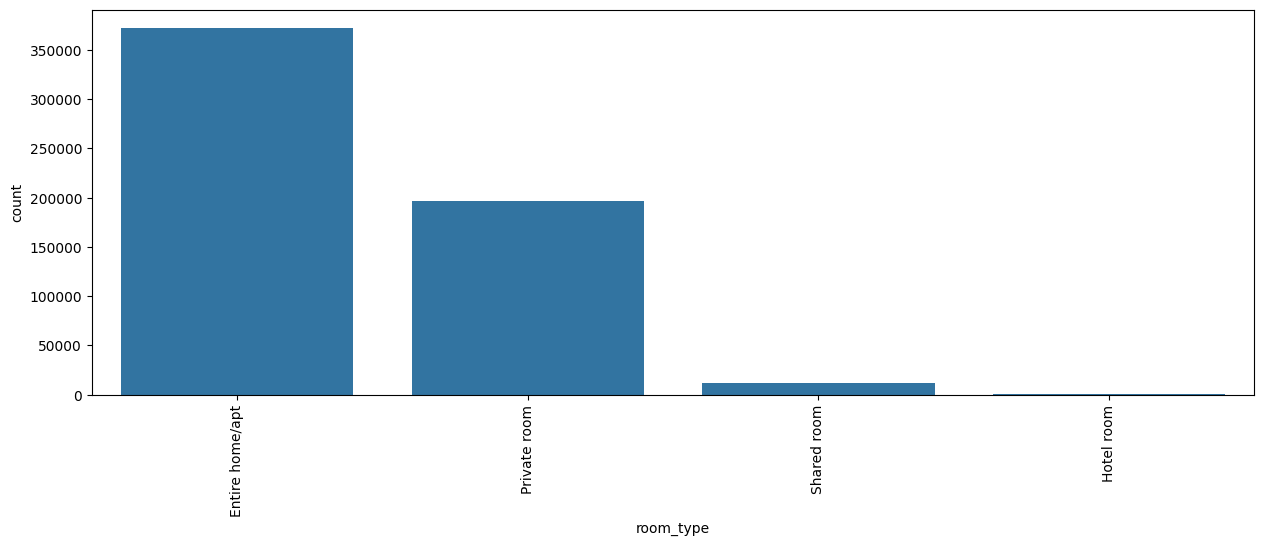

In [38]:
print(base_airbnb['room_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base_airbnb, x='room_type')
grafico.tick_params(axis='x', rotation=90 )

### bed_type

bed_type
Real Bed         570463
Pull-out Sofa      8055
Futon              1627
Airbed             1155
Couch               496
Name: count, dtype: int64


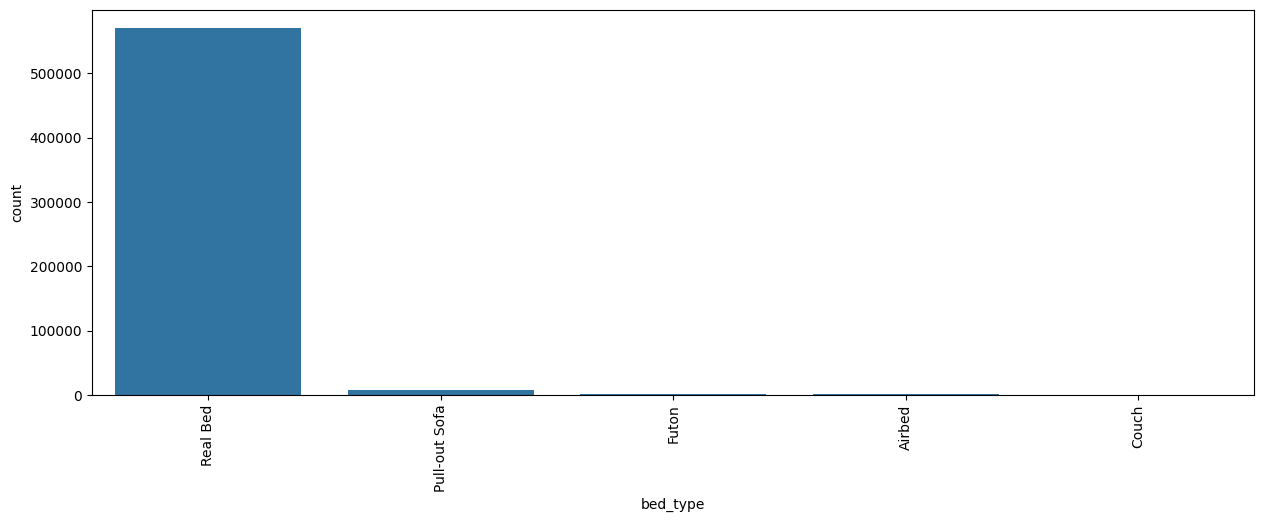

In [39]:
print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base_airbnb, x='bed_type')
grafico.tick_params(axis='x', rotation=90 )

['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']
bed_type
Real Bed      570463
Others Bed     11333
Name: count, dtype: int64


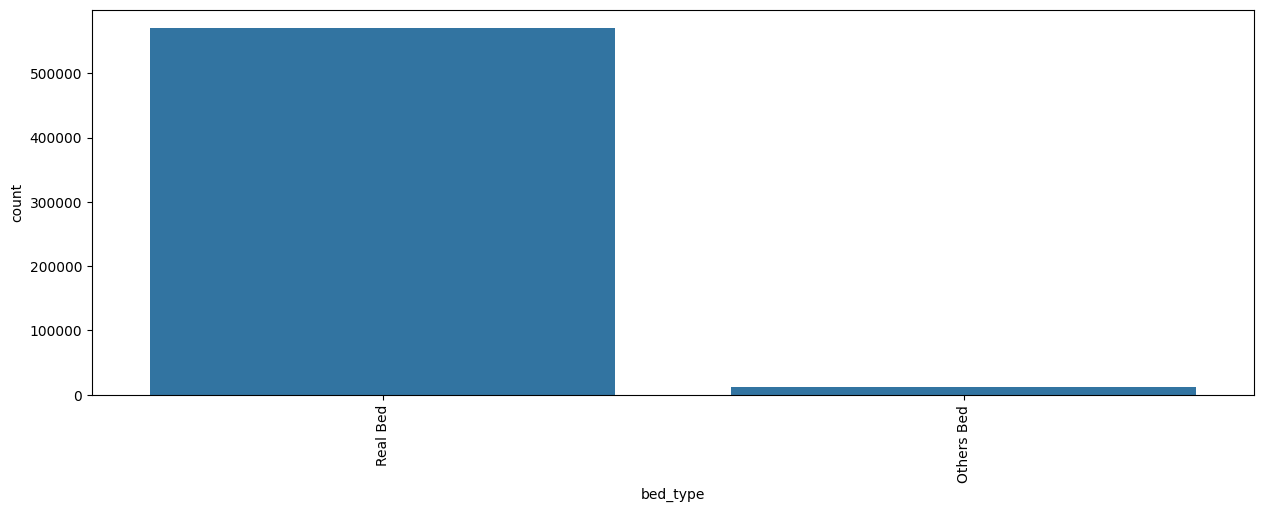

In [40]:
tabela_bed = base_airbnb['bed_type'].value_counts()
colunas_agrupar_bed = []

for tipo in tabela_bed.index:
    if tabela_bed[tipo] < 10000:
        colunas_agrupar_bed.append(tipo)
print(colunas_agrupar_bed)

for tipo in colunas_agrupar_bed:
    base_airbnb.loc[base_airbnb['bed_type']==tipo, 'bed_type'] = 'Others Bed'

print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base_airbnb, x='bed_type')
grafico.tick_params(axis='x', rotation=90)

### cancellation_policy

cancellation_policy
flexible                       258085
strict_14_with_grace_period    200623
moderate                       113241
strict                           9680
super_strict_60                   135
super_strict_30                    32
Name: count, dtype: int64


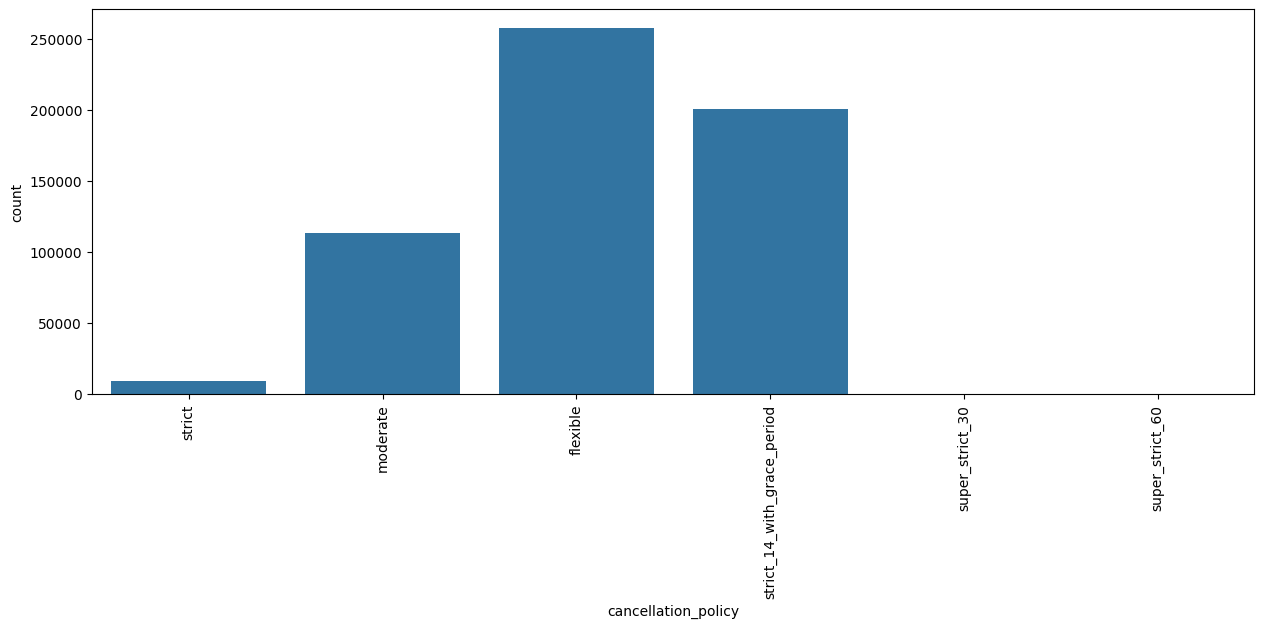

In [41]:
print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base_airbnb, x='cancellation_policy')
grafico.tick_params(axis='x', rotation=90 )







['strict', 'super_strict_60', 'super_strict_30']
cancellation_policy
flexible                       258085
strict_14_with_grace_period    200623
moderate                       113241
strict                           9847
Name: count, dtype: int64


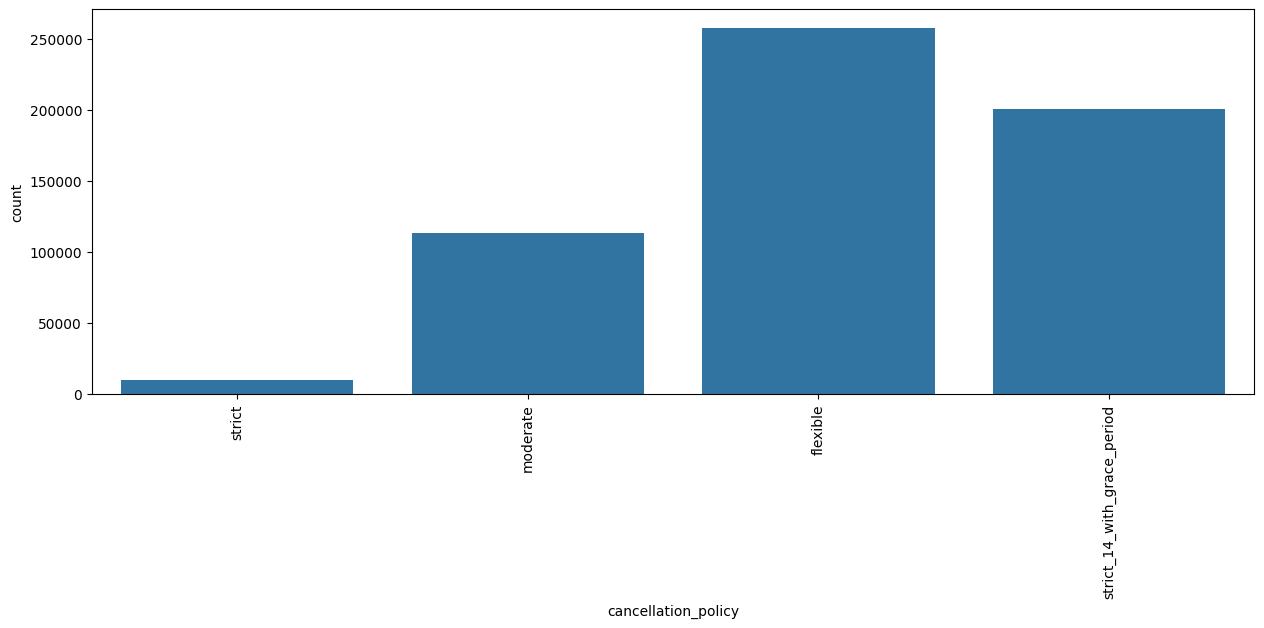

In [42]:
### Agrupando categorias de cancellation pollicy
tabela_cancellation = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 10000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy']==tipo, 'cancellation_policy'] = 'strict'

print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base_airbnb, x='cancellation_policy')
grafico.tick_params(axis='x', rotation=90)

### amenities 

Como existe uma grande diversidade de amenitie e as vezes as mesmas podem ser escitas de modos diferentes, iremos avaliar somente a quantidade existente

In [43]:
print(base_airbnb['amenities'].iloc[1].split(','))
print(len(base_airbnb['amenities'].iloc[3].split(',')))


base_airbnb['N_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)


['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', 'Doorman', 'Elevator', '"Buzzer/wireless intercom"', '"Family/kid friendly"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"}']
30


In [44]:
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

(581796, 21)

In [45]:
display(base_airbnb)

,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,...,price,extra_people,minimum_nights,number_of_reviews,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes,N_amenities
1,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,2.0,2.0,...,270.0,51.0,4,205,t,f,strict,2018,4,25
3,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,1.0,2.0,...,161.0,45.0,4,208,f,f,strict,2018,4,14
4,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,1.0,2.0,...,222.0,68.0,2,200,t,f,strict,2018,4,16
5,t,1.0,-22.988165,-43.193588,Apartment,Entire home/apt,3,1.5,1.0,2.0,...,308.0,86.0,2,116,f,f,strict,2018,4,30
6,t,1.0,-22.981269,-43.190457,Loft,Entire home/apt,2,1.0,1.0,2.0,...,219.0,80.0,3,255,t,f,strict,2018,4,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902204,f,1.0,-22.986030,-43.191660,Apartment,Entire home/apt,4,2.0,2.0,3.0,...,250.0,0.0,1,0,f,f,flexible,2019,9,15
902205,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1.0,0.0,2.0,...,121.0,50.0,1,0,f,f,flexible,2019,9,18
902206,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2.0,2.0,3.0,...,799.0,0.0,2,0,f,f,flexible,2019,9,12
902208,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1.0,1.0,1.0,...,250.0,0.0,1,0,f,f,strict_14_with_grace_period,2019,9,25


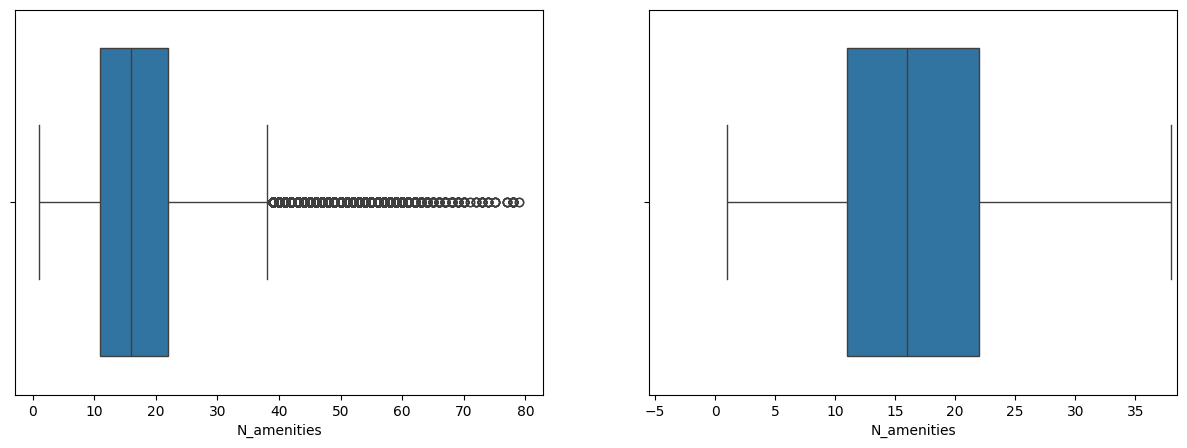

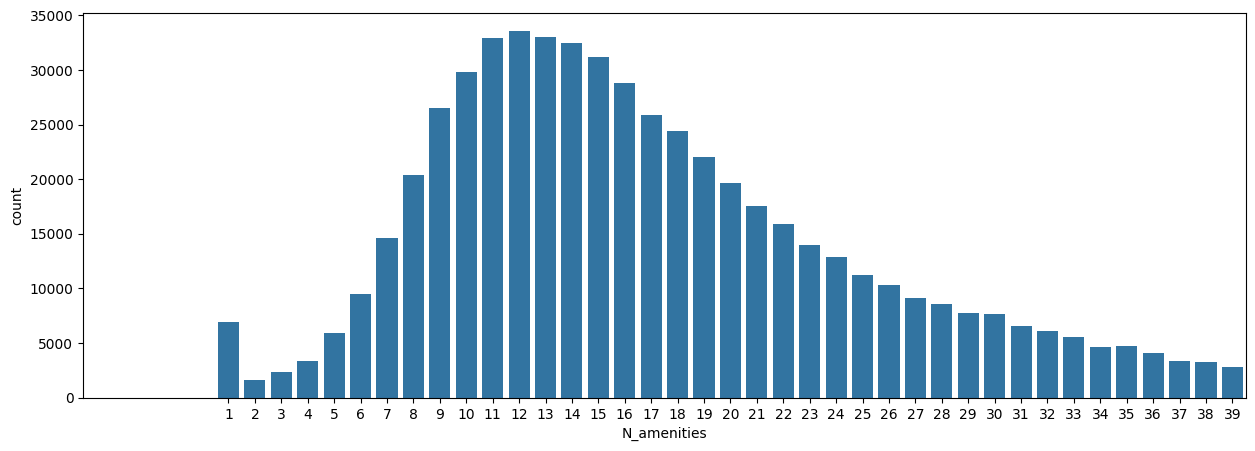

In [46]:
diagrama_caixa(base_airbnb['N_amenities'])
barra(base_airbnb['N_amenities'])

24333 linhas removidas
(557463, 21)


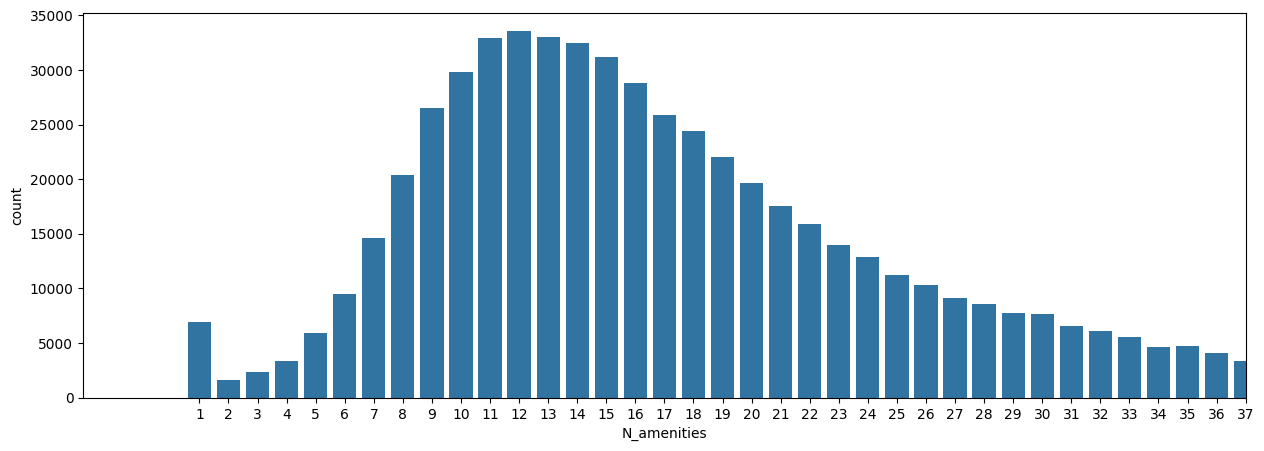

In [47]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'N_amenities')
print('{} linhas removidas'.format(linhas_removidas))
barra(base_airbnb['N_amenities'])
print(base_airbnb.shape)

### Vizualização de mapa das propriedadas 

In [ ]:
import plotly.express as px
import pandas as pd
import plotly.io as pio
pio.renderers.default='vscode'


# Verifica se há pelo menos 50.000 linhas, senão pega todas
num_linhas = len(base_airbnb)
amostra = base_airbnb.sample(n=min(50000, num_linhas), random_state=42)

# Definir centro do mapa
centro_mapa = {'lat': amostra.latitude.mean(), 'lon': amostra.longitude.mean()}




# Criar o mapa com density_mapbox (correta)
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude', z='price',
                         radius=2.5, center=centro_mapa, zoom=10,
                         mapbox_style='open-street-map')  # Certifique-se de que esse argumento está correto

# Exibir o mapa no VS Code
mapa.show()


C:\Users\GUILHERME\AppData\Local\Temp\ipykernel_2800\2186075150.py:20: DeprecationWarning:

*density_mapbox* is deprecated! Use *density_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



### Como estamos contruindo um modelo para imóveis comuns, os valores acima do limite superior serão apartamentos de luxo que não entraram no nosso modelo de previsão 


### Encoding

Precisamos ajustar as features para facilitar o trabalho do modelo futuro

* Features de valores True ou False, vamos substituir True por 1 e False por 0
* Features de cateforias, vamos utilizar o método de enconding de variáveis dummies

In [49]:
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
base_airbnb_code = base_airbnb.copy()
for coluna in colunas_tf:
    base_airbnb_code.loc[base_airbnb_code[coluna] == 't', coluna] = 1
    base_airbnb_code.loc[base_airbnb_code[coluna] == 'f', coluna] = 0

print(base_airbnb_code.iloc[0])

host_is_superhost                         1
host_listings_count                     2.0
latitude                         -22.965919
longitude                        -43.178962
property_type                   Condominium
room_type                   Entire home/apt
accommodates                              5
bathrooms                               1.0
bedrooms                                2.0
beds                                    2.0
bed_type                           Real Bed
price                                 270.0
extra_people                           51.0
minimum_nights                            4
number_of_reviews                       205
instant_bookable                          1
is_business_travel_ready                  0
cancellation_policy                  strict
ano                                    2018
mes                                       4
N_amenities                              25
Name: 1, dtype: object


In [50]:
colunas_dummies = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']

base_airbnb_code = pd.get_dummies(data=base_airbnb_code, columns=colunas_dummies)

### Modelo de Previsão

In [51]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo}:\nR²:{r2:.2%}\nRSME:{RSME:.2f}'

- Escolha dos modelos a serem testados
    1. Random Forest
    2. LinearRegression
    3. Extra Tree

In [52]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'RandomForest': modelo_rf,
          'LinearRegression': modelo_lr,
          'ExtraTrees': modelo_et,
          }

y = base_airbnb_code['price']
X = base_airbnb_code.drop('price', axis=1)

separar os dados em treino e teste + treino do modelo

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(X_train, y_train)
    #testar
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²:96.84%
RSME:47.04
Modelo LinearRegression:
R²:33.57%
RSME:215.84
Modelo ExtraTrees:
R²:97.38%
RSME:42.86


### Análise do Melhor Modelo

- Modelo escolhido como o melhor: ExtraTreesRegressor
    foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. Nota-se também que comparado aos outros modelos tivemos quase o mesmo tempo de velocidade para treinar e prever o modelo, por isso iremos optar por ele.


### Ajustes e Melhorias no Melhor Modelo

In [54]:
print(modelo_et.feature_importances_)
print(X_train.columns)



[0.0113339  0.03648313 0.09186905 0.08648383 0.06814804 0.07056967
 0.11183228 0.04642112 0.08520616 0.06203848 0.06632103 0.02090537
 0.         0.01079214 0.00448025 0.07357358 0.01250049 0.00128666
 0.00510762 0.00065949 0.00092027 0.00064505 0.00705531 0.00218496
 0.00229665 0.0021132  0.06790798 0.00036345 0.00388241 0.0018275
 0.00253835 0.00244076 0.01844859 0.01188509 0.00085778 0.00862036]
Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'extra_people',
       'minimum_nights', 'number_of_reviews', 'instant_bookable',
       'is_business_travel_ready', 'ano', 'mes', 'N_amenities',
       'property_type_Apartment', 'property_type_Bed and breakfast',
       'property_type_Condominium', 'property_type_Guest suite',
       'property_type_Guesthouse', 'property_type_Hostel',
       'property_type_House', 'property_type_Loft', 'property_type_Outros',
       'property_type_Serviced apartment', 'room_ty

,0
bedrooms,0.111832
latitude,0.091869
longitude,0.086484
extra_people,0.085206
N_amenities,0.073574
bathrooms,0.070570
accommodates,0.068148
room_type_Entire home/apt,0.067908
number_of_reviews,0.066321
minimum_nights,0.062038


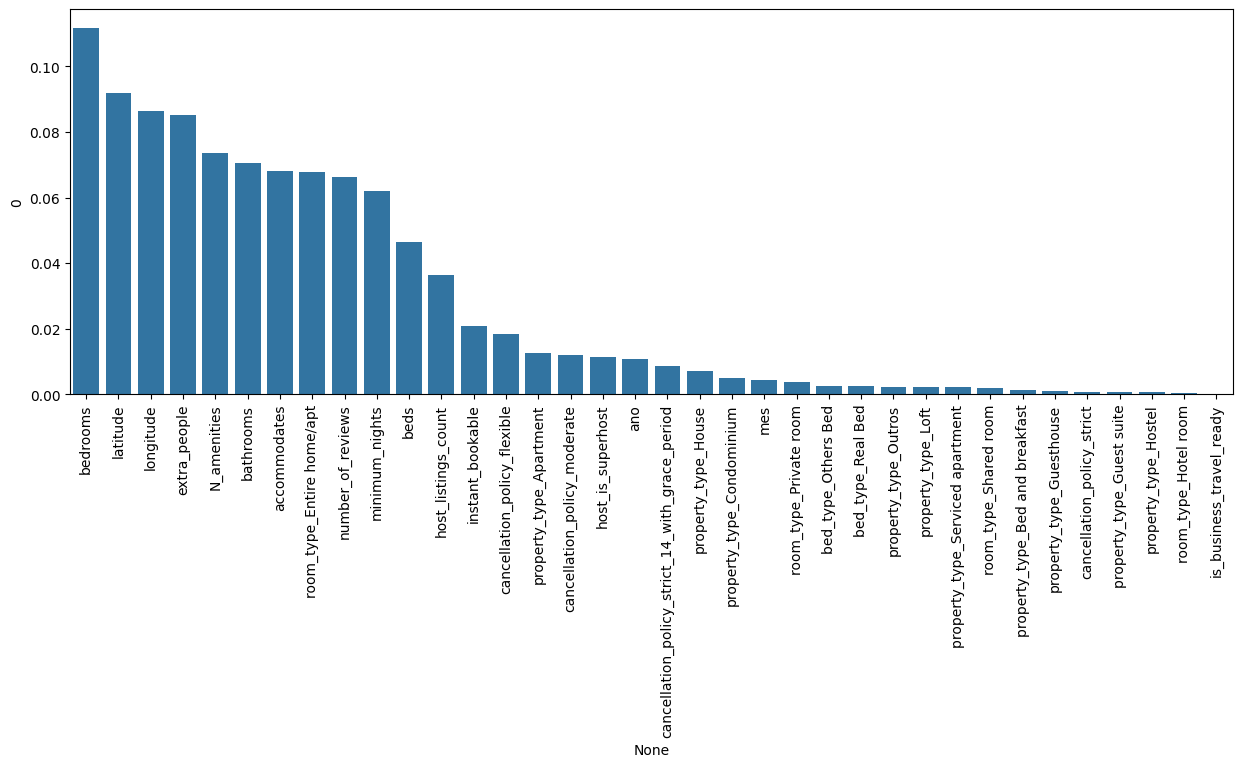

In [55]:
importancia_df = pd.DataFrame(modelo_et.feature_importances_, X_train.columns)
importancia_df = importancia_df.sort_values(by=0, ascending=False)
display(importancia_df)
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_df.index, y=importancia_df[0])
ax.tick_params(axis='x', rotation=90)
# ax.set_xlim(limites(coluna))

### Ajustes finais no modelo 
-is_business_travel_ready não trouxe valor no modelo, então iremos excluir ela para que o modelo fique mais rápid


In [56]:
base_airbnb_cod = base_airbnb_code.drop('is_business_travel_ready', axis=1)

y = base_airbnb_code['price']
X = base_airbnb_code.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Modelo ExtraTrees:
R²:97.37%
RSME:42.92


Deploy


In [64]:
X['price'] = y
X.to_csv('../app/dados.csv', index=False)

In [67]:
import joblib
joblib.dump(modelo_et, '../app/modelo.joblib')


['../app/modelo.joblib']

In [66]:
print(X_train.columns)

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'extra_people',
       'minimum_nights', 'number_of_reviews', 'instant_bookable',
       'is_business_travel_ready', 'ano', 'mes', 'N_amenities',
       'property_type_Apartment', 'property_type_Bed and breakfast',
       'property_type_Condominium', 'property_type_Guest suite',
       'property_type_Guesthouse', 'property_type_Hostel',
       'property_type_House', 'property_type_Loft', 'property_type_Outros',
       'property_type_Serviced apartment', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'bed_type_Others Bed', 'bed_type_Real Bed',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')
